In [3]:
import cryptocompare
import pandas as pd
import datetime
import time
import os
from pathlib import Path
import config

import requests
from typing import Union, Optional, List, Dict
Timestamp = Union[datetime.datetime, datetime.date, int, float]

In [4]:
# Set the API key
key = config.cryptocompare_key
cryptocompare.cryptocompare._set_api_key_parameter(key)

'&api_key=2505dbe622f0828b75b9fce3b24781f35bd23b25e6cf0ca4b118d76a9bb9e6aa'

In [5]:
# API
_URL_PRICE = 'https://min-api.cryptocompare.com/data/pricemulti?fsyms={}&tsyms={}' 
_URL_PRICE_MULTI = 'https://min-api.cryptocompare.com/data/pricemulti?fsyms={}&tsyms={}'
_URL_PRICE_MULTI_FULL = 'https://min-api.cryptocompare.com/data/pricemultifull?fsyms={}&tsyms={}'
_URL_HIST_PRICE = 'https://min-api.cryptocompare.com/data/pricehistorical?fsym={}&tsyms={}&ts={}&e={}'
_URL_HIST_PRICE_DAY = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&e={}&toTs={}'
_URL_HIST_PRICE_HOUR = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&e={}&toTs={}'
# _URL_EXCHANGES = 'https://www.cryptocompare.com/api/data/exchanges?'
_URL_EXCHANGES_HOUR = 'https://min-api.cryptocompare.com/data/exchange/histohour?tsym={}&limit={}&toTs={}'

# DEFAULTS
CURRENCY = 'USD'    # Default currency
LIMIT = 2000    # Default limit

Cryptocompare provides a Github for scraping Real-time Crypto prices. Source:
https://github.com/lagerfeuer/cryptocompare/blob/master/cryptocompare/cryptocompare.py

In [6]:

def _query_cryptocompare(url: str, errorCheck: bool = True, api_key: str = None) -> Optional[Dict]:
    """
    Query the url and return the result or None on failure.
    :param url: the url
    :param errorCheck: run extra error checks (default: True)
    :returns: respones, or nothing if errorCheck=True
    :api_key: optional, if you want to add an API Key
    """
    api_key_parameter = _set_api_key_parameter(api_key)
    try:
        response = requests.get(url + api_key_parameter).json()
    except Exception as e:
        print('Error getting coin information. %s' % str(e))
        return None
    if errorCheck and (response.get('Response') == 'Error'):
        print('[ERROR] %s' % response.get('Message'))
        return None
    return response


def _format_parameter(parameter: object) -> str:
    """
    Format the parameter depending on its type and return
    the string representation accepted by the API.
    :param parameter: parameter to format
    """
    if isinstance(parameter, list):
        return ','.join(parameter)

    else:
        return str(parameter)


def _format_timestamp(timestamp: Timestamp) -> int:
    """
    Format the timestamp depending on its type and return
    the integer representation accepted by the API.
    :param timestamp: timestamp to format
    """
    if isinstance(timestamp, datetime.datetime) or isinstance(timestamp, datetime.date):
        return int(time.mktime(timestamp.timetuple()))
    return int(timestamp)


def _set_api_key_parameter(api_key: str = None) -> str:
    if api_key is None:
        api_key = os.getenv('CRYPTOCOMPARE_API_KEY')
    if api_key is not None:
        _API_KEY = "&api_key={}".format(api_key)
        return _API_KEY
    return ""

In [7]:
def get_price(coin: str, currency: str = CURRENCY, full: bool = False) -> Optional[Dict]:
    """
    Get the currencyent price of a coin in a given currency.
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param full: full response or just the price (default: False)
    :returns: dict of coin and currency price pairs
    """
    if full:
        return _query_cryptocompare(
            _URL_PRICE_MULTI_FULL.format(
                _format_parameter(coin), _format_parameter(currency))
        )
    if isinstance(coin, list):
        return _query_cryptocompare(
            _URL_PRICE_MULTI.format(_format_parameter(coin),
                                    _format_parameter(currency))
        )
    return _query_cryptocompare(
        _URL_PRICE.format(coin, _format_parameter(currency))
    )


def get_historical_price(coin: str, currency: str = CURRENCY, timestamp: Timestamp = time.time(),
                         exchange: str = 'CCCAGG') -> Optional[Dict]:
    """
    Get the price of a coin in a given currency during a specific time.
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param timestamp: point in time
    :param exchange: the exchange to use
    :returns: dict of coin and currency price pairs
    """
    return _query_cryptocompare(
        _URL_HIST_PRICE.format(coin,
                               _format_parameter(currency),
                               _format_timestamp(timestamp),
                               _format_parameter(exchange))
    )


def get_historical_price_day(coin: str, currency: str = CURRENCY, limit: int = LIMIT,
                             exchange: str = 'CCCAGG', toTs: Timestamp = time.time()) -> Optional[Dict]:
    """
    Get historical price (day).
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param limit: number of data points (max. 2000)
    :param exchange: exchange to use (default: 'CCCAGG')
    :param toTs: return data before this timestamp. (Unix epoch time or datetime object)
    :returns: dict of coin and currency price pairs
    """
    response = _query_cryptocompare(
        _URL_HIST_PRICE_DAY.format(coin, _format_parameter(currency), limit, exchange, _format_timestamp(toTs)))
    if response:
        return response['Data']
    return None


def get_historical_price_hour(coin: str, currency: str = CURRENCY, limit: int = LIMIT,
                              exchange: str = 'CCCAGG', toTs: Timestamp = time.time()) -> Optional[Dict]:
    """
    Get historical price (hourly).
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param limit: number of data points (max. 2000)
    :param exchange: exchange to use (default: 'CCCAGG')
    :param toTs: return data before this timestamp. (Unix epoch time or datetime object)
    :returns: dict of coin and currency price pairs
    """
    response = _query_cryptocompare(
        _URL_HIST_PRICE_HOUR.format(coin, _format_parameter(currency), limit, exchange, _format_timestamp(toTs)))
    if response:
        return response['Data']
    return None


def get_exchanges(currency: str = CURRENCY, limit: int = LIMIT, toTs: Timestamp = time.time()) -> Optional[Dict]:
    """
    Get the list of available exchanges.
    :returns: list of available exchanges
    """
    response = _query_cryptocompare(_URL_EXCHANGES_HOUR.format(currency, limit, _format_timestamp(toTs)))
    if response:
        return response['Data']
    return None

### Scraping crypto prices for Price prediction 

In [8]:
# REQUEST HISTORICAL PRICE LOWER THAN THIS TIMESTAMP
# time_stamp = int(time.mktime(datetime.datetime(2022, 1, 30).timetuple()))
# print(time_stamp)

In [9]:
path = Path(f'{os.getcwd()}')
df = get_historical_price_day('BTC', 'USD', limit=2000)
# df = get_historical_price_hour('DOGE', currency='USD', limit=2000, toTs=time_stamp)
# df_volume = get_exchanges(toTs=time_stamp)

In [10]:
# Comvert df to dataframe and save to csv
df = pd.DataFrame(df)
df = df[['time', 'close']]
# df = df[['time', 'volume']]
df['time'] = pd.to_datetime(df['time'], unit='s')


df = df.sort_values(by=['time'], ascending=False)
# print(df.head())

In [11]:
# print first and last elemnt column time
print(df.iloc[0])
print(df.iloc[-1])

time     2022-04-21 00:00:00
close                41390.9
Name: 2000, dtype: object
time     2016-10-29 00:00:00
close                 714.95
Name: 0, dtype: object


In [12]:
df.to_csv(f"{path}\DOGE-price_history-raw.csv")

### Data filtering

In [13]:
# Read csv file in new_df
new_df = df.copy()

# Remove Unnamed column
# new_df = new_df.drop(columns=['Unnamed: 0'])
# print(new_df.head())

# filter data after Jan 2021 until present time
new_df = new_df[new_df['time'] > '2021-01-01']



# Filter data to only show data between 21 Feb 2022 and now
# df_volume = new_df[(new_df['time'] >= '2022-01-12') & (new_df['time'] <= '2022-01-30')]

# Save updated prices from filtered_df to a csv file
# df_volume.to_csv(f"{path}\DOGE-price-filtered.csv")

In [14]:
from matplotlib import pyplot as plt


In [15]:
# RUPTURES PACKAGE. 
import ruptures as rpt
import numpy as np

def retrieve_time_series(api, series_ID):
    """ Retrieve time series data from the API.
    Parameters
    —------—
    api : API object
    series_ID : string, ID of the time series
    """

    series_search = api.data_by_series(series=series_ID)
    df = pd.DataFrame(series_search)

    return df

###############################################################################

new_df.rename(columns={'date':'Date'}, inplace=True)
# Create a copy of merged_df to price_df
price_df = new_df.copy()

# Process the dataframe and convert the close column to numpy array
points=np.array(price_df['close'])

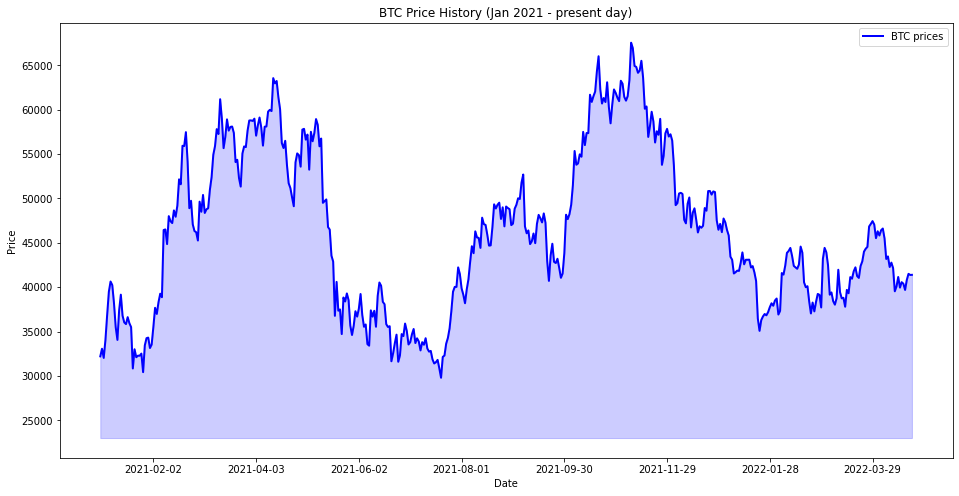

In [16]:
# sort the data based on time column
new_df = new_df.sort_values(by=['time'], ascending=False)

# plot the new_df on time axis
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(new_df['time'], new_df['close'], color='blue', label='BTC prices', linewidth=2)
# display the points and result 
# add a legend
ax.legend()
# set the x axis label
ax.set_xlabel('Date')
# set the y axis label
ax.set_ylabel('Price')
# set the title
ax.set_title('BTC Price History (Jan 2021 - present day)')
# set the x axis tick labels only days not hours
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# add more labels on the y axis
ax.yaxis.set_major_locator(plt.MaxNLocator(10))

# fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, **kwargs)
ax.fill_between(new_df['time'], new_df['close'], 23000, color='blue', alpha=0.2)
plt.show()



In [23]:
def retrieve_time_series(api, series_ID):
    """ Retrieve time series data from the API.
    Parameters
    —------—
    api : API object
    series_ID : string, ID of the time series
    """

    series_search = api.data_by_series(series=series_ID)
    df = pd.DataFrame(series_search)

    return df

###############################################################################

new_df.rename(columns={'date':'Date'}, inplace=True)



# Create a copy of merged_df to price_df
price_df = new_df.copy()

# sort price dataframe by time
price_df = price_df.sort_values(by=['time'], ascending=True)

# Process the dataframe and convert the close column to numpy array
points=np.array(price_df['close'])





# The Pelt search method is the most efficient, but requires the user to specify
# the number of breakpoints.

# The Binary Segmentation search method is the most efficient, but requires the
# user to specify the number of breakpoints.

# The 'dynamic' method, which uses a fixed window size and a fixed number of
# breakpoints, but also allows for the removal of outliers.

    

In [24]:
# Changepoint detection with the Pelt search method. model rbf is the default kernel used by the Pelt method. 
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=1)



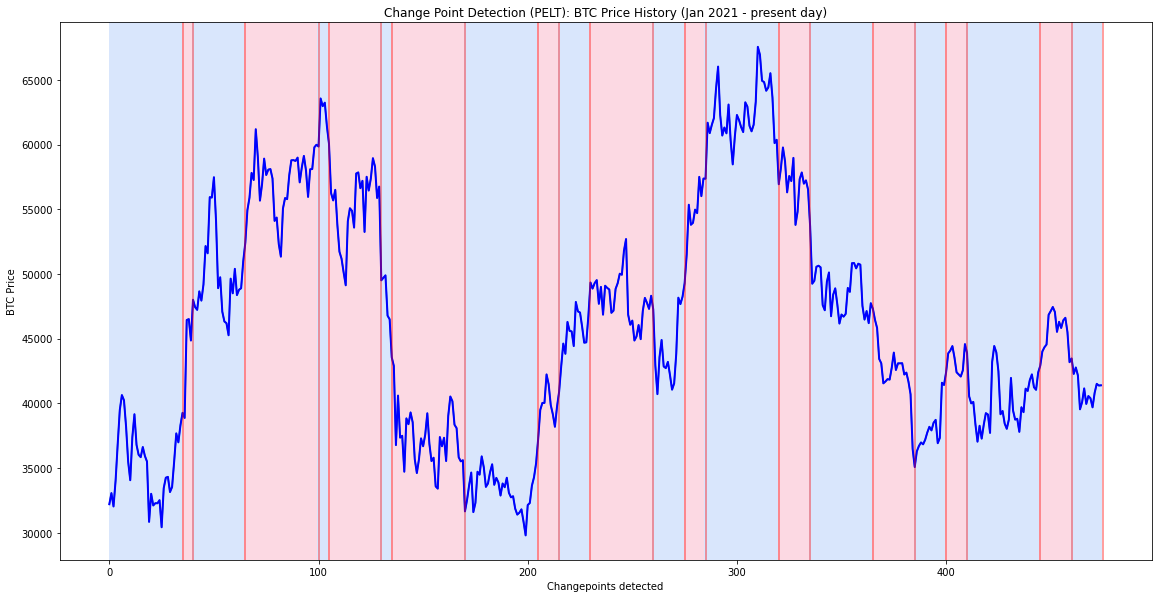

In [25]:
rpt.display(points, result, figsize=(16, 8))
# plot the point with a linewidth of 2
plt.plot(points, linewidth=2, color='blue')
# plot the lines at the change points
for i in range(len(result)):
    plt.axvline(x=result[i], color='red', linestyle='-', alpha=0.5)
plt.title('Change Point Detection (PELT): BTC Price History (Jan 2021 - present day)')
# set x-axis label
plt.xlabel('Changepoints detected')
# set y-axis label
plt.ylabel('BTC Price')

plt.show()  